In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import time
from tqdm import tqdm

class ExamEA:
    def __init__(self, num_exams, num_periods, conflict_matrix, params):
        self.num_exams = num_exams
        self.num_periods = num_periods
        self.conflict_matrix = conflict_matrix
        self.params = params

    def calculate_fitness(self, chromosome):
        """Vectorized Fitness: Penalty = (Total Student Conflicts) * 1000"""
        penalty = 0
        for p in range(1, self.num_periods + 1):
            exams_in_p = np.where(chromosome == p)[0]
            if len(exams_in_p) > 1:
                # Sub-matrix lookup is the fastest way in NumPy
                sub_matrix = self.conflict_matrix[np.ix_(exams_in_p, exams_in_p)]
                penalty += np.sum(sub_matrix) // 2
        return float(penalty * 1000)

    def select(self, population, fits, scheme, count=2):
        pop_size = len(population)
        if scheme == "Random":
            idx = np.random.choice(pop_size, count, replace=False)
        elif scheme == "Binary Tournament":
            def tourney():
                i, j = np.random.choice(pop_size, 2, replace=False)
                return i if fits[i] < fits[j] else j
            idx = [tourney() for _ in range(count)]
        elif scheme == "FPS":
            inv_fits = 1.0 / (np.array(fits) + 1e-9)
            probs = inv_fits / inv_fits.sum()
            idx = np.random.choice(pop_size, count, p=probs, replace=False)
        elif scheme == "Rank":
            ranks = np.argsort(np.argsort(fits)[::-1]) + 1
            probs = ranks / ranks.sum()
            idx = np.random.choice(pop_size, count, p=probs, replace=False)
        elif scheme == "Truncation":
            idx = np.argsort(fits)[:count]
        return [population[i] for i in idx]

    def run_ea(self, p_scheme, s_scheme):
        pop = [np.random.randint(1, self.num_periods + 1, self.num_exams) for _ in range(self.params['pop_size'])]
        bsf_history, asf_history = [], []
        best_overall = float('inf')

        for gen in range(self.params['generations']):
            fits = [self.calculate_fitness(ind) for ind in pop]

            current_best = min(fits)
            best_overall = min(best_overall, current_best)
            bsf_history.append(best_overall)
            asf_history.append(np.mean(fits))

            offspring = []
            for _ in range(self.params['num_offspring']):
                p1, p2 = self.select(pop, fits, p_scheme, count=2)
                # One-point Crossover
                pt = random.randint(0, self.num_exams - 1)
                child = np.concatenate([p1[:pt], p2[pt:]])
                # Mutation
                if random.random() < self.params['mutation_rate']:
                    child[random.randint(0, self.num_exams - 1)] = random.randint(1, self.num_periods)
                offspring.append(child)

            # Survival Strategy
            combined_pop = pop + offspring
            combined_fits = fits + [self.calculate_fitness(o) for o in offspring]

            if s_scheme == "Truncation":
                indices = np.argsort(combined_fits)[:self.params['pop_size']]
                pop = [combined_pop[i] for i in indices]
            else: # Random survival
                indices = np.random.choice(len(combined_pop), self.params['pop_size'], replace=False)
                pop = [combined_pop[i] for i in indices]

        return bsf_history, asf_history

def parse_data(file):
    tree = ET.parse(file)
    root = tree.getroot()
    num_exams = len(root.findall('exams/exam'))
    num_periods = len(root.findall('periods/period'))
    matrix = np.zeros((num_exams, num_exams), dtype=int)
    for s in root.findall('students/student'):
        e_ids = [int(e.get('id')) - 1 for e in s.findall('exam')]
        for i in range(len(e_ids)):
            for j in range(i + 1, len(e_ids)):
                matrix[e_ids[i], e_ids[j]] += 1
                matrix[e_ids[j], e_ids[i]] += 1
    return num_exams, num_periods, matrix

In [ ]:
# 1. INITIALIZE DATA
num_ex, num_per, conf_m = parse_data('pu-exam-spr09.xml')

# 2. BEST SUITED CONFIGURATION
config = {
    'pop_size': 50,
    'num_offspring': 20,
    'generations': 100,
    'mutation_rate': 0.3,
    'iterations': 10
}

# Combinations required by assignment
combinations = [
    ("FPS", "Truncation"),
    ("Binary Tournament", "Truncation"),
    ("Truncation", "Truncation"),
    ("Random", "Random"),
    ("Rank", "Random")
]

engine = ExamEA(num_ex, num_per, conf_m, config)

# Create a folder for the results
if not os.path.exists('ea_results'): os.makedirs('ea_results')

for p_scheme, s_scheme in combinations:
    name = f"{p_scheme}_vs_{s_scheme}"
    print(f"\n🚀 Starting: {name}")

    bsf_master = []
    asf_master = []

    for i in tqdm(range(config['iterations']), desc=f"Runs of {name}"):
        bsf, asf = engine.run_ea(p_scheme, s_scheme)
        bsf_master.append(bsf)
        asf_master.append(asf)

        # SAVE INTERMEDIATE DATA (Safety first!)
        df_bsf = pd.DataFrame(bsf_master)
        df_asf = pd.DataFrame(asf_master)
        df_bsf.to_csv(f'ea_results/{name}_BSF_raw.csv')
        df_asf.to_csv(f'ea_results/{name}_ASF_raw.csv')

print("\n✅ ALL EXPERIMENTS FINISHED and SAVED to /ea_results folder.")


🚀 Starting: FPS_vs_Truncation


Runs of FPS_vs_Truncation: 100%|██████████| 10/10 [06:19<00:00, 37.98s/it]



🚀 Starting: Binary Tournament_vs_Truncation


Runs of Binary Tournament_vs_Truncation: 100%|██████████| 10/10 [06:50<00:00, 41.06s/it]



🚀 Starting: Truncation_vs_Truncation


Runs of Truncation_vs_Truncation: 100%|██████████| 10/10 [06:14<00:00, 37.48s/it]



🚀 Starting: Random_vs_Random


Runs of Random_vs_Random: 100%|██████████| 10/10 [06:11<00:00, 37.13s/it]



🚀 Starting: Rank_vs_Random


Runs of Rank_vs_Random: 100%|██████████| 10/10 [06:10<00:00, 37.03s/it]


✅ ALL EXPERIMENTS FINISHED and SAVED to /ea_results folder.


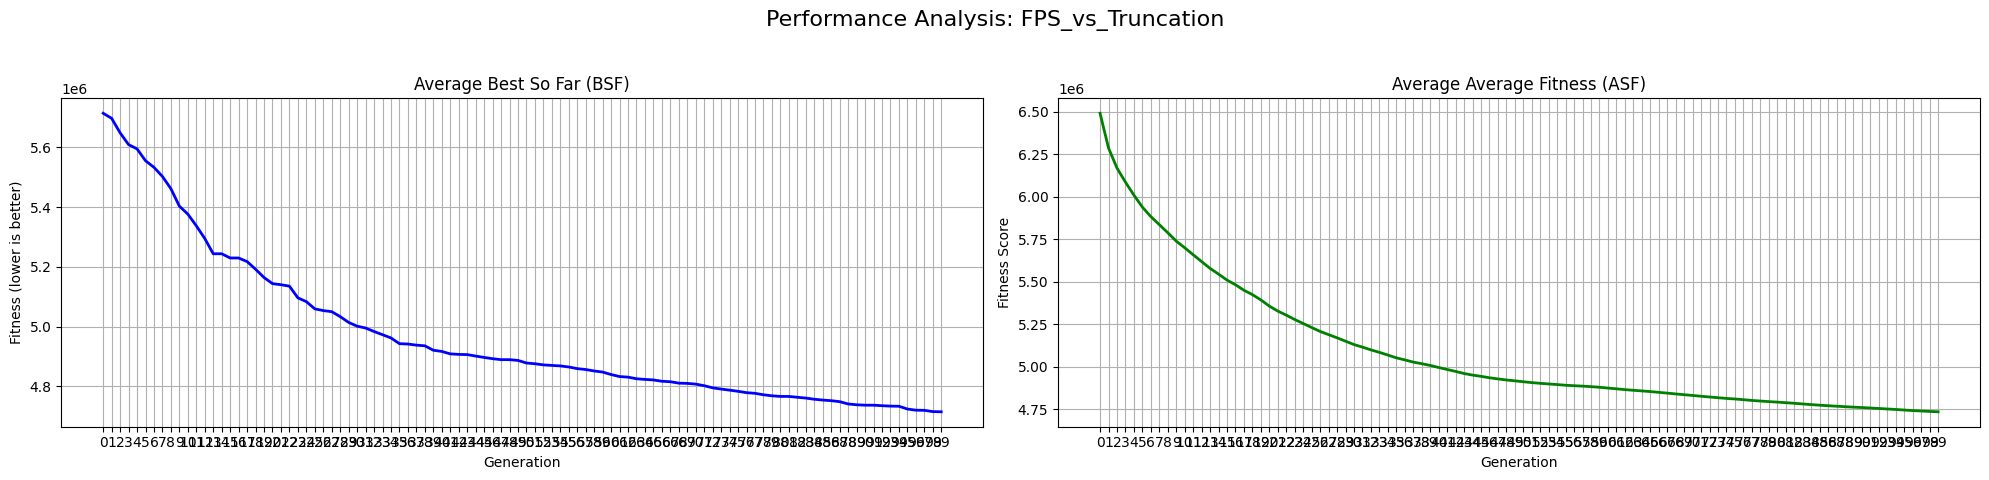

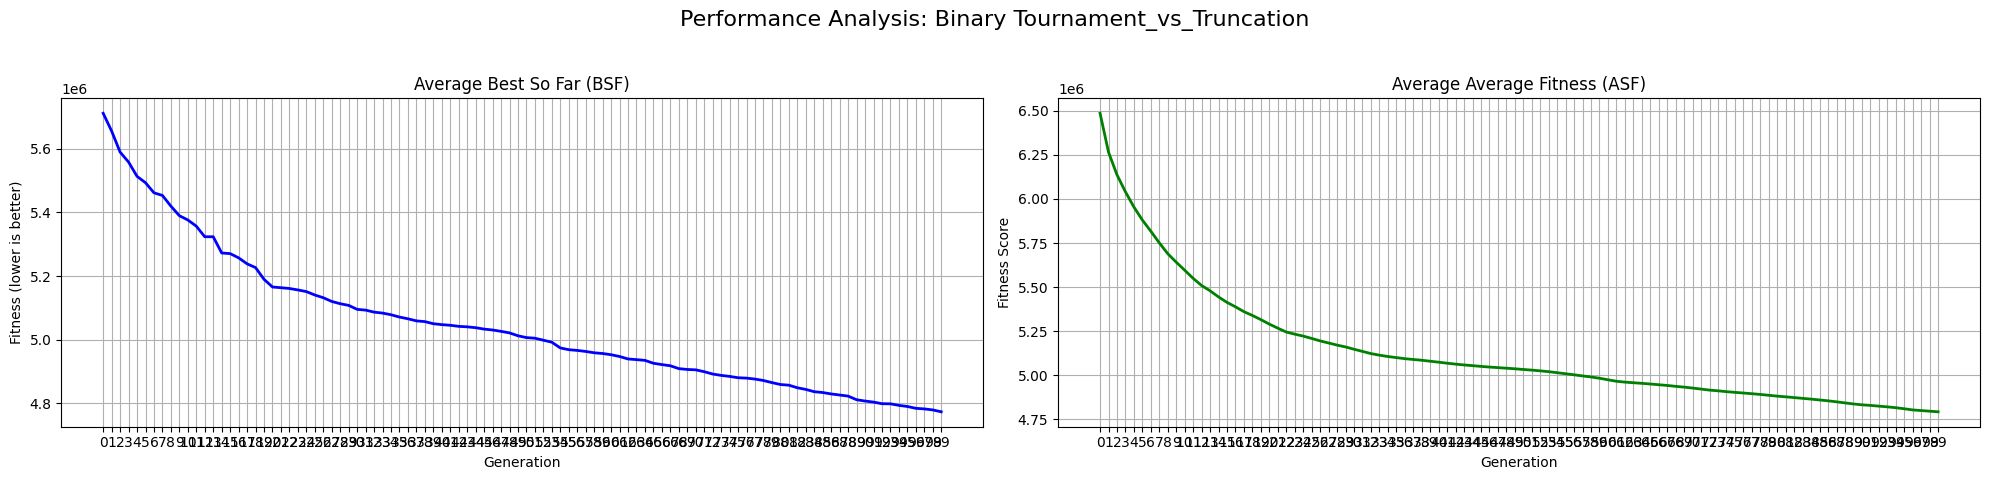

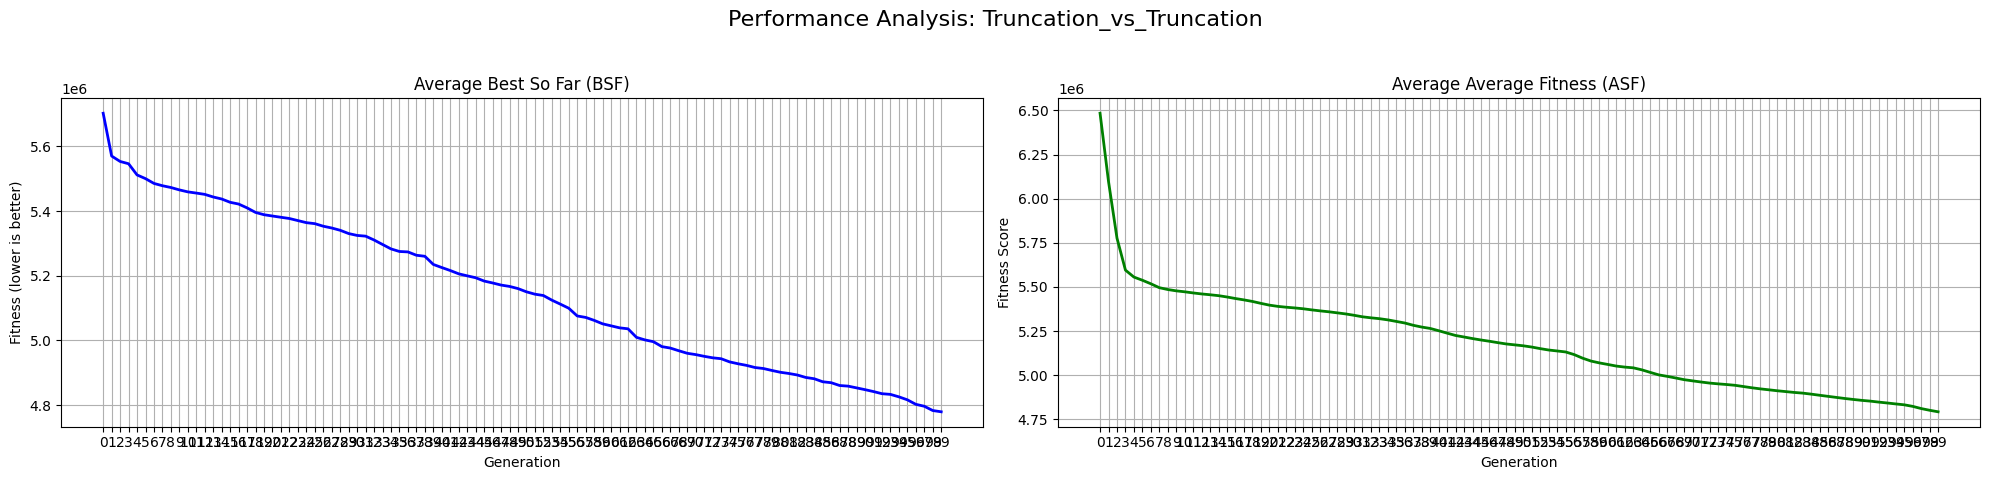

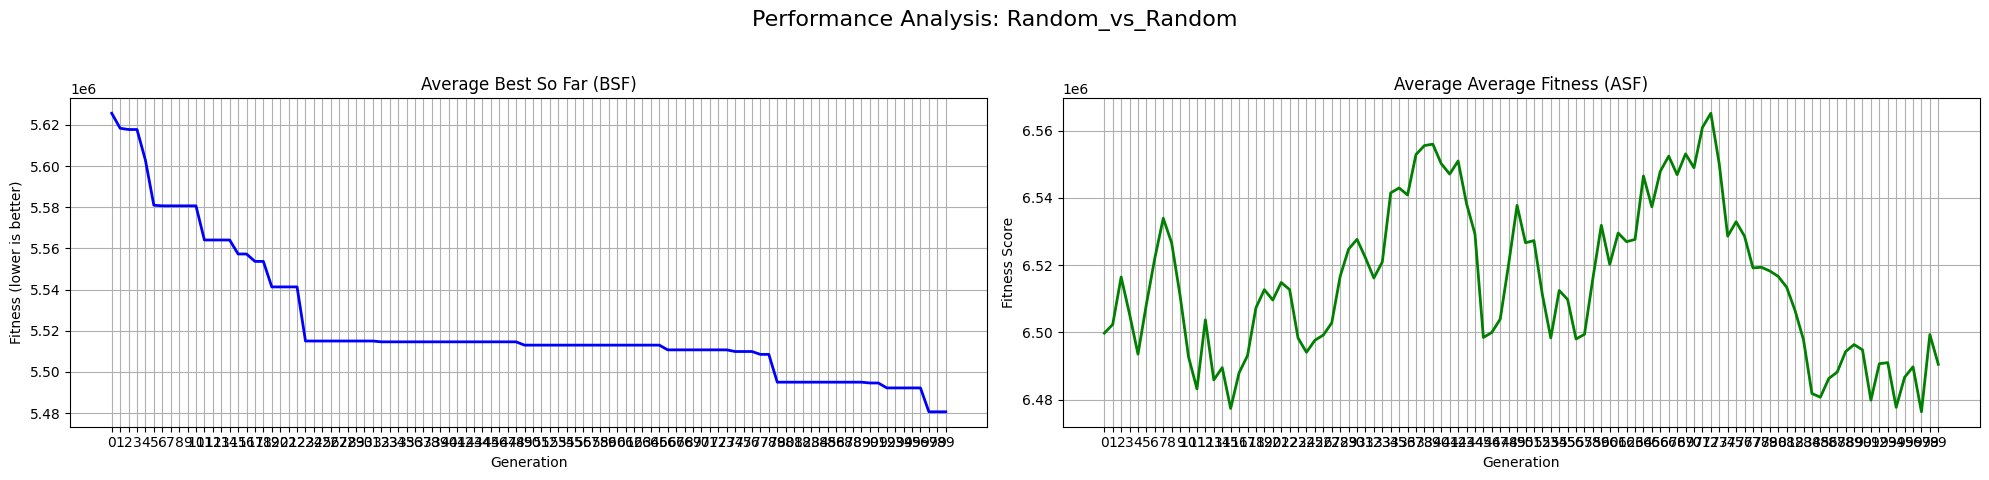

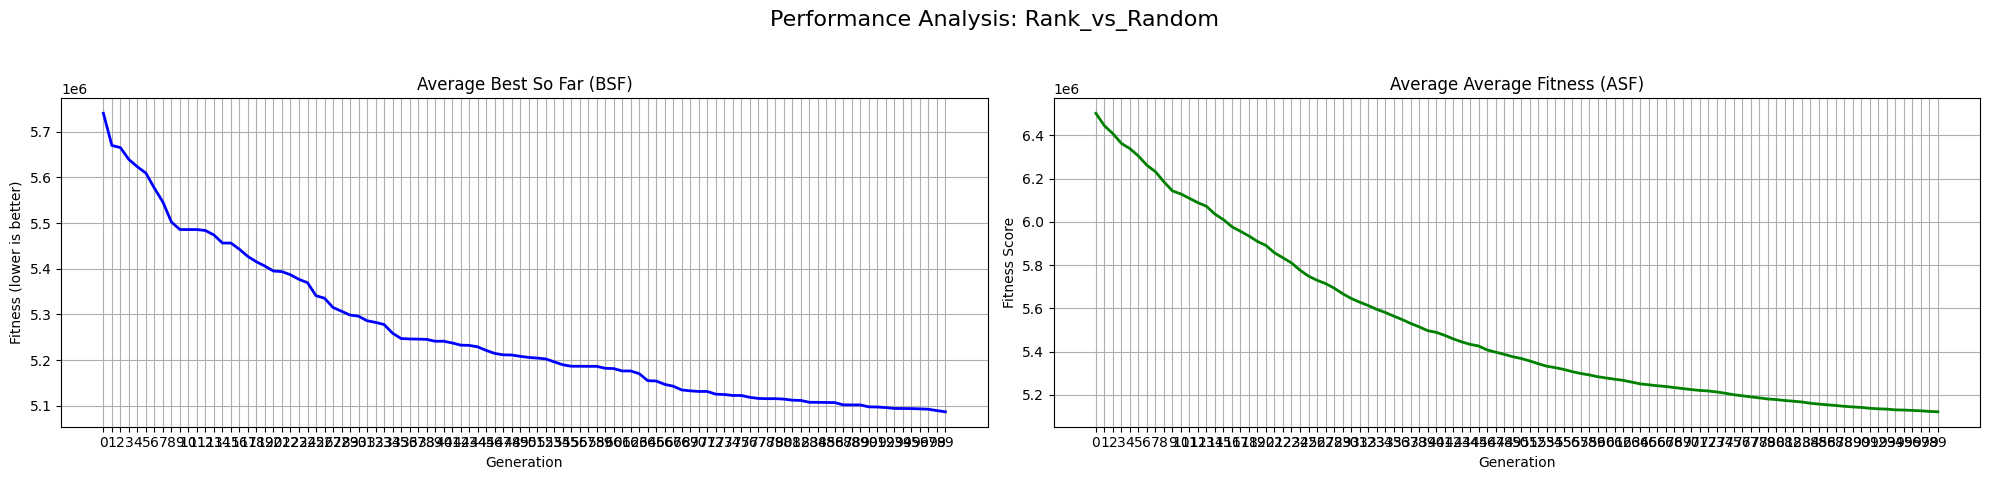

In [ ]:
def plot_results(name):
    bsf_df = pd.read_csv(f'ea_results/{name}_BSF_raw.csv', index_col=0)
    asf_df = pd.read_csv(f'ea_results/{name}_ASF_raw.csv', index_col=0)

    avg_bsf = bsf_df.mean(axis=0)
    avg_asf = asf_df.mean(axis=0)

    plt.figure(figsize=(20, 5))
    plt.suptitle(f"Performance Analysis: {name}", fontsize=16)

    # BSF Plot
    plt.subplot(1, 2, 1)
    plt.plot(avg_bsf, color='blue', linewidth=2)
    plt.title("Average Best So Far (BSF)")
    plt.xlabel("Generation")
    plt.ylabel("Fitness (lower is better)")
    plt.grid(True)

    # ASF Plot
    plt.subplot(1, 2, 2)
    plt.plot(avg_asf, color='green', linewidth=2)
    plt.title("Average Average Fitness (ASF)")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Score")
    plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualize everything
for p, s in combinations:
    plot_results(f"{p}_vs_{s}")

Fixed Labels (old ones were wrong)

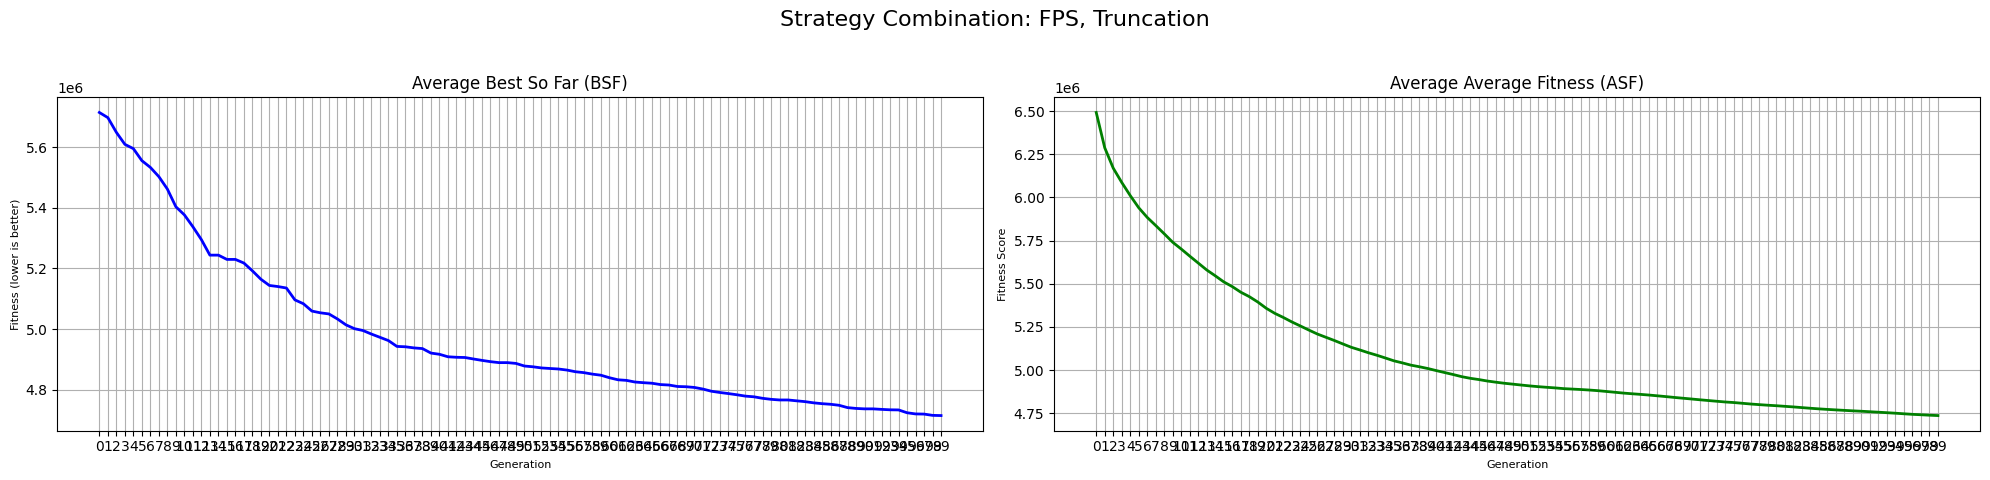

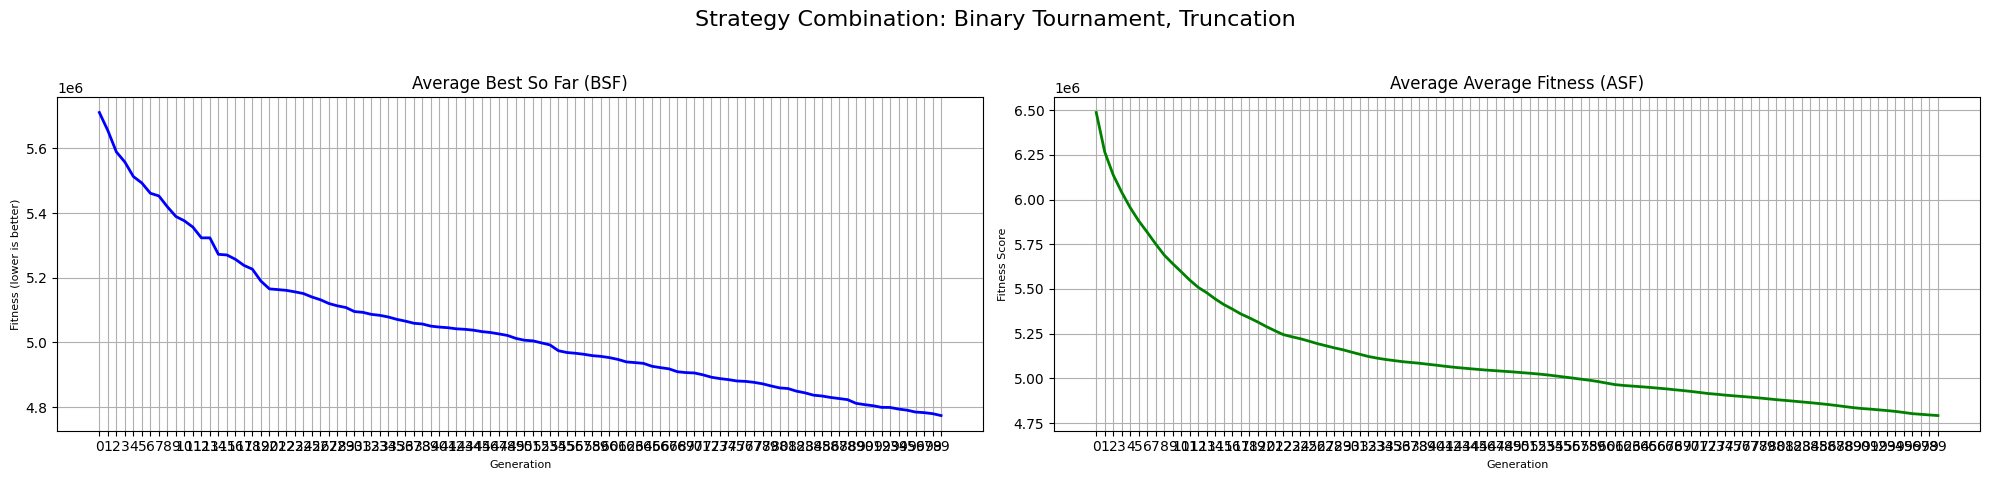

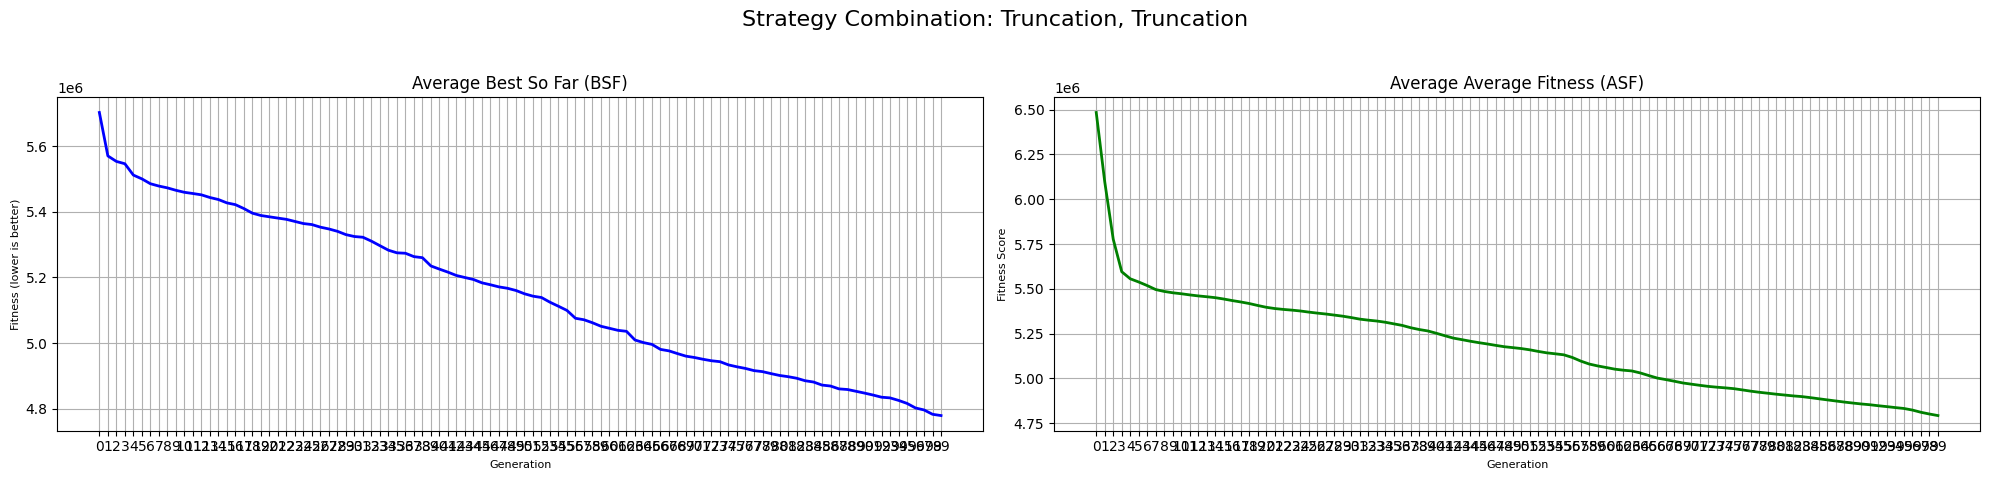

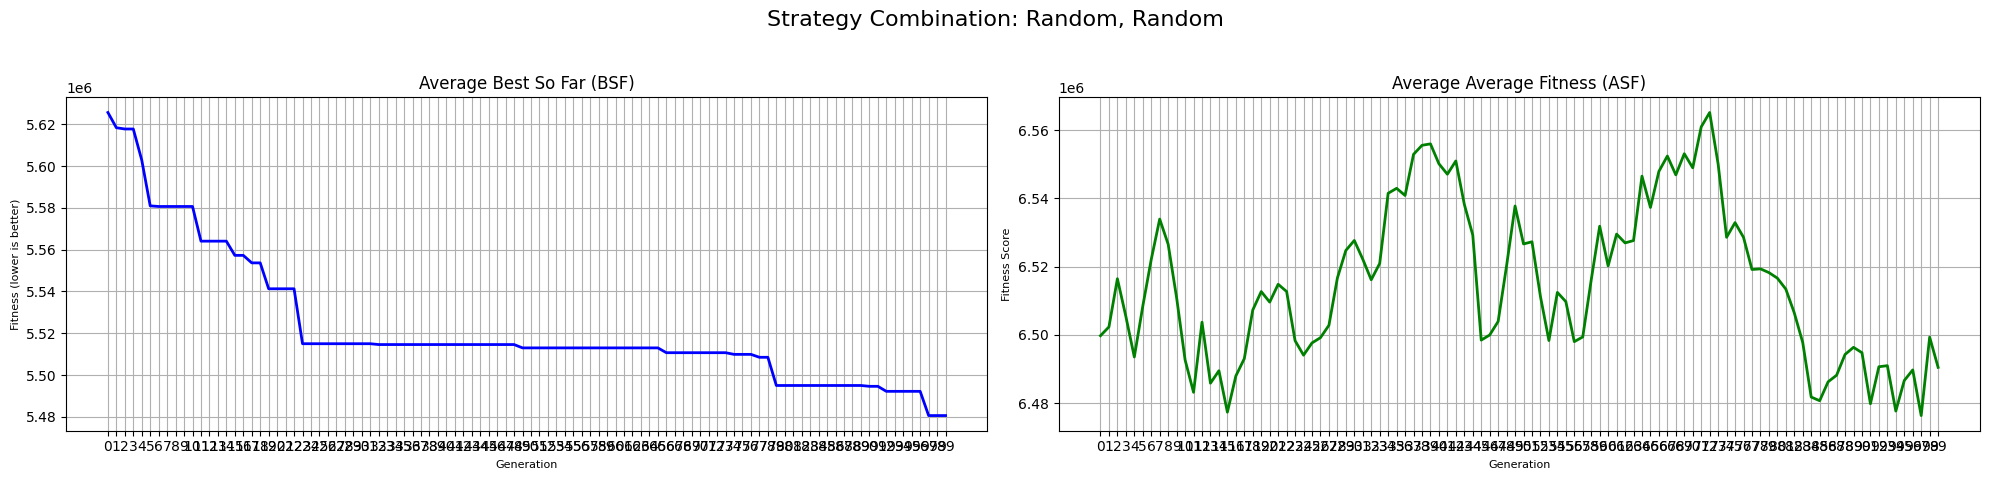

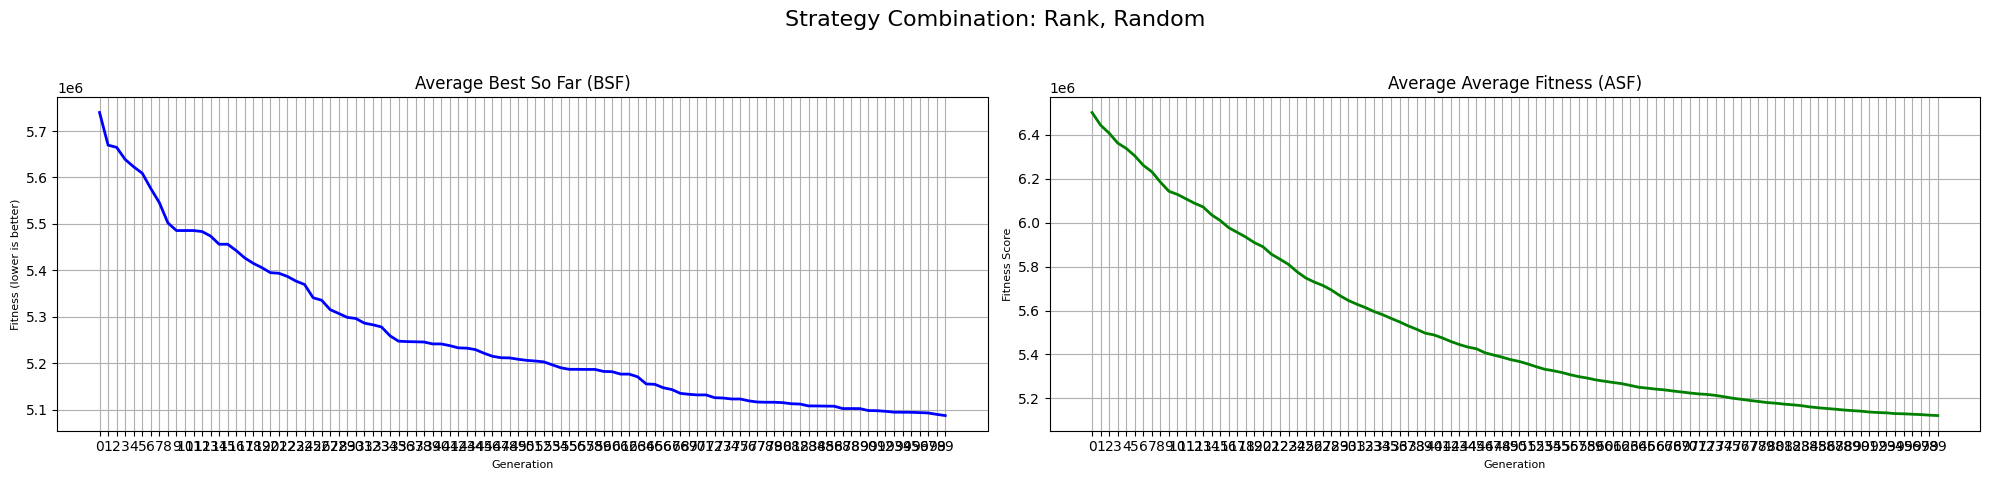

In [ ]:
def plot_results(name):
    bsf_df = pd.read_csv(f'ea_results/{name}_BSF_raw.csv', index_col=0)
    asf_df = pd.read_csv(f'ea_results/{name}_ASF_raw.csv', index_col=0)

    avg_bsf = bsf_df.mean(axis=0)
    avg_asf = asf_df.mean(axis=0)

    plt.figure(figsize=(20, 5))

    # Format the name for the title
    formatted_name = name.replace('_vs_', ', ')
    plt.suptitle(f"Strategy Combination: {formatted_name}", fontsize=16)

    # BSF Plot
    plt.subplot(1, 2, 1)
    plt.plot(avg_bsf, color='blue', linewidth=2)
    plt.title("Average Best So Far (BSF)")
    plt.xlabel("Generation", fontsize=8)
    plt.ylabel("Fitness (lower is better)", fontsize=8)
    plt.grid(True)
    plt.tick_params(axis='x', labelsize=8) # Set x-axis tick label font size
    plt.tick_params(axis='y', labelsize=8) # Set y-axis tick label font size

    # ASF Plot
    plt.subplot(1, 2, 2)
    plt.plot(avg_asf, color='green', linewidth=2)
    plt.title("Average Average Fitness (ASF)")
    plt.xlabel("Generation", fontsize=8)
    plt.ylabel("Fitness Score", fontsize=8)
    plt.grid(True)
    plt.tick_params(axis='x', labelsize=8) # Set x-axis tick label font size
    plt.tick_params(axis='y', labelsize=8) # Set y-axis tick label font size

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualize everything
for p, s in combinations:
    plot_results(f"{p}_vs_{s}")

**Visualising and Comparing Combinations.**

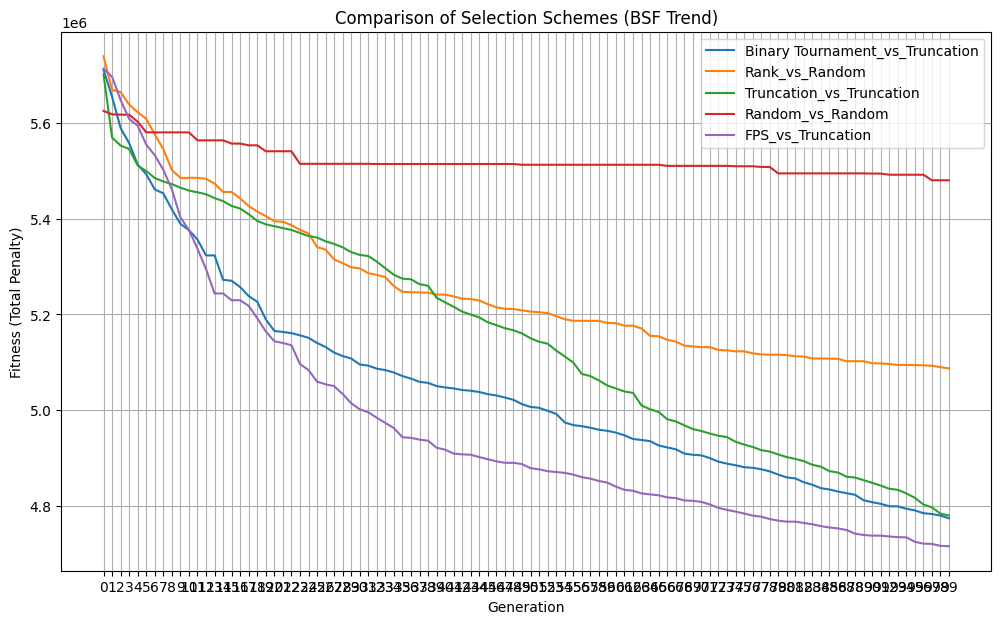


🏆 EVOLUTIONARY ALGORITHM LEADERBOARD 🏆
                         Scheme  Initial BSF (Avg)  Final BSF (Avg)  Improvement %  Consistency (Std)
              FPS_vs_Truncation          5713800.0        4715400.0      17.473485      115147.441714
Binary Tournament_vs_Truncation          5711400.0        4773600.0      16.419792      127139.643262
       Truncation_vs_Truncation          5702000.0        4779600.0      16.176780      124699.817339
                 Rank_vs_Random          5740000.0        5087200.0      11.372822      191521.858341
               Random_vs_Random          5625700.0        5480600.0       2.579235      124946.388503

🥇 THE WINNING STRATEGY: FPS_vs_Truncation


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def analyze_results(folder='ea_results'):
    summary = []
    files = [f for f in os.listdir(folder) if f.endswith('_BSF_raw.csv')]

    plt.figure(figsize=(12, 7))

    for f in files:
        name = f.replace('_BSF_raw.csv', '')
        bsf_df = pd.read_csv(f'{folder}/{f}', index_col=0)

        # Calculate Metrics
        initial_fitness = bsf_df.iloc[:, 0].mean()
        final_fitness = bsf_df.iloc[:, -1].mean()
        improvement = ((initial_fitness - final_fitness) / initial_fitness) * 100
        consistency = bsf_df.iloc[:, -1].std() # Lower std means the EA is reliable

        summary.append({
            'Scheme': name,
            'Initial BSF (Avg)': initial_fitness,
            'Final BSF (Avg)': final_fitness,
            'Improvement %': improvement,
            'Consistency (Std)': consistency
        })

        # Plotting the Average BSF trend for all schemes
        plt.plot(bsf_df.mean(axis=0), label=name)

    plt.title("Comparison of Selection Schemes (BSF Trend)")
    plt.xlabel("Generation")
    plt.ylabel("Fitness (Total Penalty)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Display Leaderboard
    df_summary = pd.DataFrame(summary).sort_values(by='Final BSF (Avg)')
    print("\n" + "="*50)
    print("🏆 EVOLUTIONARY ALGORITHM LEADERBOARD 🏆")
    print("="*50)
    print(df_summary.to_string(index=False))

    winner = df_summary.iloc[0]['Scheme']
    print(f"\n🥇 THE WINNING STRATEGY: {winner}")
    return winner

# Run the analysis
winner_name = analyze_results()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os

source_folder = 'ea_results'
destination_folder = '/content/drive/MyDrive/CI_ASS1/ea_results_backup'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Copy the entire folder
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
print(f"'{source_folder}' copied to '{destination_folder}' successfully!")

'ea_results' copied to '/content/drive/MyDrive/CI_ASS1/ea_results_backup' successfully!


**Finetuning to get better results from the leading strategy combination.**

In [7]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import time
from tqdm import tqdm

# --- 1. THE BASE ENGINE ---
class ExamEA:
    def __init__(self, num_exams, num_periods, conflict_matrix, params):
        self.num_exams = num_exams
        self.num_periods = num_periods
        self.conflict_matrix = conflict_matrix
        self.params = params

    def calculate_fitness(self, chromosome):
        penalty = 0
        for p in range(1, self.num_periods + 1):
            exams_in_p = np.where(chromosome == p)[0]
            if len(exams_in_p) > 1:
                sub_matrix = self.conflict_matrix[np.ix_(exams_in_p, exams_in_p)]
                penalty += np.sum(sub_matrix) // 2
        return float(penalty * 1000)

    def mutate(self, child):
        """Standard Random Reset Mutation"""
        if random.random() < self.params['mutation_rate']:
            child[random.randint(0, self.num_exams - 1)] = random.randint(1, self.num_periods)
        return child

    def select(self, population, fits, scheme, count=2):
        pop_size = len(population)
        if scheme == "FPS":
            inv_fits = 1.0 / (np.array(fits) + 1e-9)
            probs = inv_fits / inv_fits.sum()
            idx = np.random.choice(pop_size, count, p=probs, replace=False)
        elif scheme == "Truncation":
            idx = np.argsort(fits)[:count]
        # (Other schemes omitted for brevity as FPS/Truncation are the winners)
        return [population[i] for i in idx]

    def run_ea(self, p_scheme, s_scheme):
        pop = [np.random.randint(1, self.num_periods + 1, self.num_exams) for _ in range(self.params['pop_size'])]
        bsf_history, asf_history = [], []
        best_overall = float('inf')

        for gen in range(self.params['generations']):
            fits = [self.calculate_fitness(ind) for ind in pop]
            current_best = min(fits)
            best_overall = min(best_overall, current_best)
            bsf_history.append(best_overall)
            asf_history.append(np.mean(fits))

            offspring = []
            for _ in range(self.params['num_offspring']):
                p1, p2 = self.select(pop, fits, p_scheme, count=2)
                pt = random.randint(0, self.num_exams - 1)
                child = np.concatenate([p1[:pt], p2[pt:]])
                child = self.mutate(child) # This now correctly calls EliteEA's version
                offspring.append(child)

            combined_pop = pop + offspring
            combined_fits = fits + [self.calculate_fitness(o) for o in offspring]

            if s_scheme == "Truncation":
                indices = np.argsort(combined_fits)[:self.params['pop_size']]
                pop = [combined_pop[i] for i in indices]
            else:
                indices = np.random.choice(len(combined_pop), self.params['pop_size'], replace=False)
                pop = [combined_pop[i] for i in indices]

        return bsf_history, asf_history

# --- 2. DATA PARSING ---
def parse_data(file):
    tree = ET.parse(file)
    root = tree.getroot()
    num_exams = len(root.findall('exams/exam'))
    num_periods = len(root.findall('periods/period'))
    matrix = np.zeros((num_exams, num_exams), dtype=int)
    for s in root.findall('students/student'):
        e_ids = [int(e.get('id')) - 1 for e in s.findall('exam')]
        for i in range(len(e_ids)):
            for j in range(i + 1, len(e_ids)):
                matrix[e_ids[i], e_ids[j]] += 1
                matrix[e_ids[j], e_ids[i]] += 1
    return num_exams, num_periods, matrix

# --- 3. SUPER-RUN EXECUTION ---
if not os.path.exists('ea_results'): os.makedirs('ea_results')
num_ex, num_per, conf_m = parse_data('pu-exam-spr09.xml')

elite_config = {
    'pop_size': 200,
    'num_offspring': 40,
    'generations': 500,
    'mutation_rate': 0.4,
    'iterations': 1
}

class EliteEA(ExamEA):
    def mutate(self, chromo):
        """Advanced Swap Mutation + Random Reset"""
        if random.random() < self.params['mutation_rate']:
            if random.random() < 0.5:
                idx = random.randint(0, self.num_exams - 1)
                chromo[idx] = random.randint(1, self.num_periods)
            else:
                idx1, idx2 = np.random.choice(self.num_exams, 2, replace=False)
                chromo[idx1], chromo[idx2] = chromo[idx2], chromo[idx1]
        return chromo

elite_engine = EliteEA(num_ex, num_per, conf_m, elite_config)
bsf_super, asf_super = [], []

print(f"🔥 Starting ELITE Super-Run...")
for i in tqdm(range(elite_config['iterations'])):
    bsf, asf = elite_engine.run_ea("FPS", "Truncation")
    bsf_super.append(bsf)
    asf_super.append(asf)

    # Persistent saving
    pd.DataFrame(bsf_super).to_csv('ea_results/SUPER_RUN_FPS_BSF.csv')
    pd.DataFrame(asf_super).to_csv('ea_results/SUPER_RUN_FPS_ASF.csv')

print("\n✨ Super-Run Complete!")

🔥 Starting ELITE Super-Run...


100%|██████████| 1/1 [13:31<00:00, 811.68s/it]


✨ Super-Run Complete!


--- SUPER-RUN DIAGNOSTICS ---
Generations recorded: 500
Starting Fitness: 5,687,000
Ending Fitness:   3,488,000
Total Drop:       2,199,000

✅ SUCCESS: The EA successfully minimized conflicts.
✅ SUCCESS: All 500 generations were recorded.


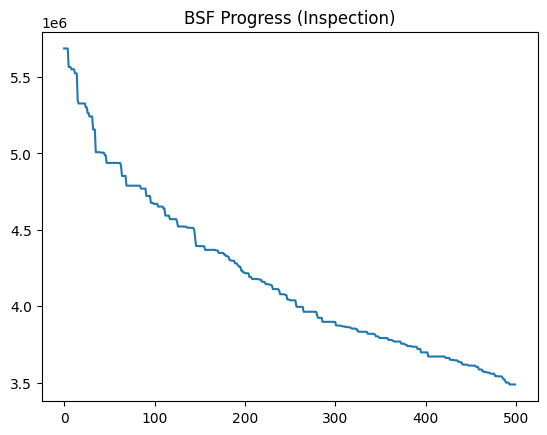

In [9]:
# 1. Load the data
bsf_inspect = pd.read_csv('ea_results/SUPER_RUN_FPS_BSF.csv', index_col=0)
asf_inspect = pd.read_csv('ea_results/SUPER_RUN_FPS_ASF.csv', index_col=0)

# 2. Extract first and last values
initial_val = bsf_inspect.iloc[0, 0]
final_val = bsf_inspect.iloc[0, -1]
total_improvement = initial_val - final_val

print(f"--- SUPER-RUN DIAGNOSTICS ---")
print(f"Generations recorded: {len(bsf_inspect.columns)}")
print(f"Starting Fitness: {initial_val:,.0f}")
print(f"Ending Fitness:   {final_val:,.0f}")
print(f"Total Drop:       {total_improvement:,.0f}")

if total_improvement > 0:
    print("\n✅ SUCCESS: The EA successfully minimized conflicts.")
    if len(bsf_inspect.columns) == 500:
        print("✅ SUCCESS: All 500 generations were recorded.")
else:
    print("\n⚠️ WARNING: No improvement detected. Something might be wrong with the loop.")

# 3. Quick Peek at the curve
plt.plot(bsf_inspect.iloc[0].values)
plt.title("BSF Progress (Inspection)")
plt.show()

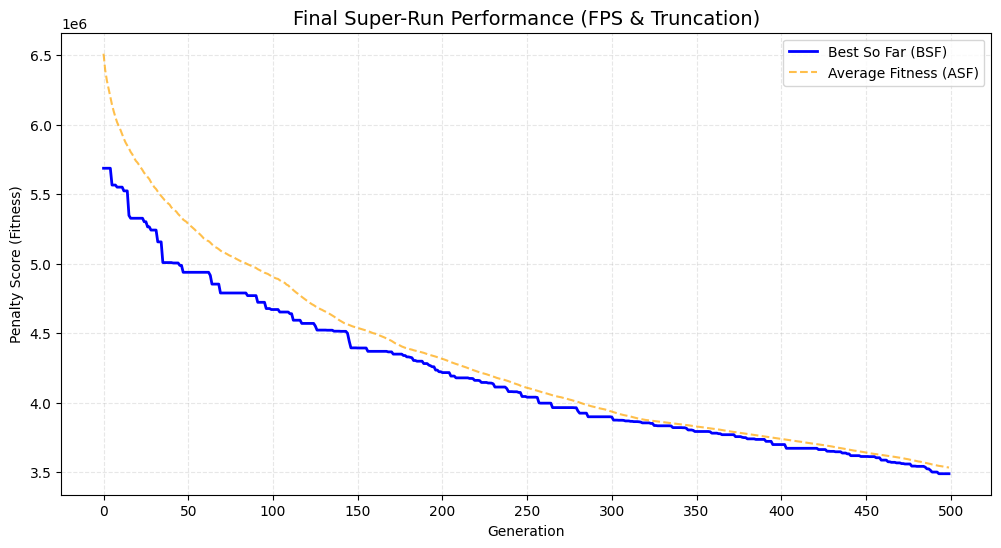

Final Optimized Score: 3488000.00


In [10]:
import numpy as np

# Load saved data
bsf_final = pd.read_csv('ea_results/SUPER_RUN_FPS_BSF.csv', index_col=0)
asf_final = pd.read_csv('ea_results/SUPER_RUN_FPS_ASF.csv', index_col=0)

# Calculate Average across runs
avg_bsf = bsf_final.mean(axis=0)
avg_asf = asf_final.mean(axis=0)

plt.figure(figsize=(12, 6))
plt.plot(avg_bsf.values, label='Best So Far (BSF)', color='blue', linewidth=2)
plt.plot(avg_asf.values, label='Average Fitness (ASF)', color='orange', linestyle='--', alpha=0.7)

# --- X-AXIS MODIFICATION ---
# This sets ticks from 0 to 500 in steps of 50
plt.xticks(np.arange(0, 501, 50))

plt.title('Final Super-Run Performance (FPS & Truncation)', fontsize=14)
plt.xlabel('Generation')
plt.ylabel('Penalty Score (Fitness)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.3)

plt.show()

print(f"Final Optimized Score: {avg_bsf.iloc[-1]:.2f}")